In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from giopy import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'prisma.csv'
fr = pd.read_csv(FILE)
fr = fr.sort_values('RIFLESSA deg')

In [11]:
# START,,RIFLESSA deg,RIFLESSA prim,GIALLO deg,GIALLO prim,VERDE deg,VERDE prim,BLU deg,BLU prim,VIOLA deg,VIOLA prim

ang_incidente = np.array(fr['RIFLESSA deg'] + 0.01*fr['RIFLESSA prim']/6) * np.pi/180 * 0.5
giallo = np.array(fr['GIALLO deg'] + 0.01*fr['GIALLO prim']/6) * np.pi/180
verde = np.array(fr['VERDE deg'] + 0.01*fr['VERDE prim']/6) * np.pi/180
blu = np.array(fr['BLU deg'] + 0.01*fr['BLU prim']/6) * np.pi/180
viola = np.array(fr['VIOLA deg'] + 0.01*fr['VIOLA prim']/6) * np.pi/180

sigma = 0.5 * np.pi/180

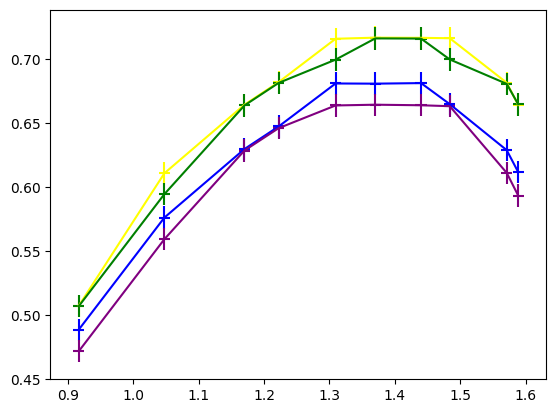

In [12]:
plt.errorbar(ang_incidente,giallo,yerr=sigma,xerr=sigma,color='yellow')
plt.errorbar(ang_incidente,verde,yerr=sigma,xerr=sigma,color='green')
plt.errorbar(ang_incidente,blu,yerr=sigma,xerr=sigma,color='blue')
plt.errorbar(ang_incidente,viola,yerr=sigma,xerr=sigma,color='purple')
plt.show()
